# Human Pose Estimation - Part 5

# Model Deployment / Inference Demo

## Get Model Checkpoint from Google Drive

In [14]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Capture an Image from the Webcam

In [0]:
# Frame capture function

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.9):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

def get_webcam_photo():
  # capture image
  try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
  except Exception as err:
    print(str(err))   


## Run the Person Detector

In [0]:
'''
detect_object_fastercnn

This function will perform inference on the fastercnn model to get back the
labels, scores, and bounding boxes for each object detected in the image.
It will then filter only the objects with label as `label_to_detect`
and plot the corresponding bounding boxes on the original image as long as
the detected object has a score > `score_threshold`

'''
# load a model pre-trained on COCO
import time
import torchvision
from torch import nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
model_faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_faster_rcnn.to('cuda')
model_faster_rcnn.eval()
PERSON_LABEL = 1

# inference function
def detect_object_fastercnn(img, label_to_detect=PERSON_LABEL, score_threshold=0.75, model=model_faster_rcnn, device='cuda'):
    
    # Generate the input tensor and normalize
    img_tensor = torch.tensor(np.asarray(img)).permute(2,0,1).unsqueeze(0)
    img_tensor = img_tensor.float()/255.0 # Cast & Normalize
    img_tensor = img_tensor.to(device)
     
    # Do inference
    with torch.no_grad():
        predictions = model(img_tensor)

    # Get the bounding boxes of the relevant objects
    object_indices = (predictions[0]['labels'] == label_to_detect).nonzero()
    boxes = predictions[0]['boxes'][object_indices].int().cpu().numpy()
    scores = predictions[0]['scores'][object_indices].cpu().numpy()
    num_objects_detected = boxes.shape[0]

    # For each object box, plot the bounding-box on the original image:
    displayed_objects = 0
    colors = ["blue", "green", "red", "pink","yellow"]
    person_boxes = []
    for i in range(num_objects_detected):
        if scores[i][0] > score_threshold:
            person_boxes.append(boxes[i][0])

    return person_boxes

## Run the Keypoint Estimator

In [0]:
# Image Preprocessing
def preprocess_input_image(img, boxes, input_width=192, input_height=256):
    
    # Rescale Input Image
    x_start, y_start, x_end, y_end = boxes
    rescaled_img = img.resize((input_width,input_height), box=(x_start, y_start, x_end, y_end))
    rescaled_img = np.array(rescaled_img)
        
    # normalize input image
    mean=np.asarray([0.485, 0.456, 0.406])
    std=np.asarray([0.229, 0.224, 0.225])
    rescaled_img = rescaled_img.astype('float32')/255.0
    input_image = (rescaled_img - mean) / std
    input_image_tensor = torch.tensor(rescaled_img).permute(2,0,1).float().unsqueeze(0).to('cuda')

    return input_image_tensor, rescaled_img
    

In [0]:
## Our own model architecture

# Expected accuracy ~0.6
class ConvDeconvNet(nn.Module):

    def __init__(self):
        super(ConvDeconvNet,self).__init__()
        #Convolution 1
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64, kernel_size=7,stride=2, padding=3)
        nn.init.normal_(self.conv1.weight, std=0.001)
        nn.init.constant_(self.conv1.bias, 0)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1= nn.ReLU()
        self.maxpool1= nn.MaxPool2d(kernel_size=2,stride=2)

        #Convolution 2
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128, kernel_size=5,stride=1, padding=2)
        nn.init.normal_(self.conv2.weight, std=0.001)
        nn.init.constant_(self.conv2.bias, 0)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2= nn.ReLU()
        self.maxpool2= nn.MaxPool2d(kernel_size=2,stride=2)
        
        #Convolution 3
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256, kernel_size=5,stride=1, padding=2)
        nn.init.normal_(self.conv3.weight, std=0.001)
        nn.init.constant_(self.conv3.bias, 0)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3= nn.ReLU()
        self.maxpool3= nn.MaxPool2d(kernel_size=2,stride=2)
        
        #Deconvolution 4
        self.deconv4 =nn.ConvTranspose2d(in_channels=256,out_channels=256,padding=1, output_padding=0,kernel_size=4, stride=2)
        nn.init.normal_(self.deconv4.weight, std=0.001)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4= nn.ReLU(inplace=True)
        
        #Deconvolution 5
        self.deconv5 =nn.ConvTranspose2d(in_channels=256,out_channels=256,padding=1, output_padding=0,kernel_size=4, stride=2)
        nn.init.normal_(self.deconv5.weight, std=0.001)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5= nn.ReLU(inplace=True)
        
        ### final layer declaration
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=17, kernel_size=1) # 17 joints -> out_channel=17
        nn.init.normal_(self.conv6.weight, std=0.001)
        nn.init.constant_(self.conv6.bias, 0)
        
    def forward(self,x):
        # conv layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        # deconv layer
        x = self.deconv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        
        x = self.deconv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        
        # final layer
        x = self.conv6(x)
        return(x)

In [0]:
## Resnet50 Architecture

# pytorch resnet implementation
# https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html
# Training accuracy: ~0.6

import torch
import torch.nn as nn
from torch.utils.model_zoo import load_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetPose(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNetPose, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        
        ### not needed
        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
                    
                    
        ### deconvolutional layers declaration
        self.deconv5 =nn.ConvTranspose2d(in_channels=2048,out_channels=256,padding=1, output_padding=0, kernel_size=4, stride=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5= nn.ReLU(inplace=True)
        
        self.deconv6 =nn.ConvTranspose2d(in_channels=256,out_channels=256,padding=1, output_padding=0,kernel_size=4, stride=2)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6= nn.ReLU(inplace=True)
        
        self.deconv7 =nn.ConvTranspose2d(in_channels=256,out_channels=256,padding=1, output_padding=0,kernel_size=4, stride=2)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7= nn.ReLU(inplace=True)
        
        ### final layer declaration
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=17, kernel_size=1) # 17 joints -> out_channel=17
        
        
        ### init weights
        self.init_weights()


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)
      

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        ### deconvolution layers
        x = self.deconv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        
        x = self.deconv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        
        x = self.deconv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        
        ### final layer
        x = self.conv8(x)

        return x
      
    def init_weights(self):
        
        # init deconv layers
        nn.init.normal_(self.deconv5.weight, std=0.001)
        nn.init.constant_(self.deconv5.bias, 0)
        nn.init.constant_(self.bn5.weight, 1)
        nn.init.constant_(self.bn5.bias, 0)
        
        nn.init.normal_(self.deconv6.weight, std=0.001)
        nn.init.constant_(self.deconv6.bias, 0)
        nn.init.constant_(self.bn6.weight, 1)
        nn.init.constant_(self.bn6.bias, 0)
        
        nn.init.normal_(self.deconv7.weight, std=0.001)
        nn.init.constant_(self.deconv7.bias, 0)
        nn.init.constant_(self.bn7.weight, 1)
        nn.init.constant_(self.bn7.bias, 0)
        
        # init final layer
        nn.init.normal_(self.conv8.weight, std=0.001)
        nn.init.constant_(self.conv8.bias, 0)
      
      
def resnetpose_pretrained():
  
    model = ResNetPose(Bottleneck, [3, 4, 6, 3])
    
    # load pretrained weights
    state_dict = load_url(model_urls['resnet50'],progress=True)
    model.load_state_dict(state_dict,strict=False)
    return model    

In [0]:
# initialize Keypoint Estimation Model

# Uncomment these 2 lines for our own architecture
# model = ConvDeconvNet() 
# checkpoint_path = "drive/My Drive/Manning/data/ConvDeconvNet_9_3508.pth" # Checkpoint of own architecture

# Uncomment these 2 lines for pretrained Resnet50
model = resnetpose_pretrained() # uncomment this line 
checkpoint_path = "drive/My Drive/Manning/data/resnetpose_0_3500.pth"    # Checkpoint of pretrained Resnet50 architecture

# load model weights
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cuda'))
model.load_state_dict(checkpoint['model'])
model.to('cuda')
model.eval()

def get_heatmap_prediction(img):
    with torch.no_grad():
        heatmap = model(input_image_tensor) #predict keypoiont heatmaps  
    heatmap = heatmap.cpu().numpy()
    return heatmap

## Find Keypoint Locations

In [0]:
# find keypoint locations in heatmap
def find_max_in_heatmap(heatmap, input_width=192, input_height=256):
    heatmap_dims = np.asarray(heatmap.shape[2:4])
    img_dims = np.asarray([input_height,input_width])
  
    keypointPositions = []
    scores = []
    for k in range(heatmap.shape[1]):
        hm_layer = heatmap[0,k,:,:]
        [x,y] = np.asarray(np.unravel_index(np.argmax(hm_layer, axis=None), hm_layer.shape)) # get max location for this layer
        score = hm_layer[x,y] # get max score as confidence of the prediction
        keypointPositions.append([x,y])
        scores.append(score)

    keypointPositions = np.asarray(keypointPositions)
    scores = np.asarray(scores)
    keypointPositions = keypointPositions*img_dims/heatmap_dims
    return keypointPositions,scores

## Plot Result

In [0]:
# function to plot keypoints
THRESHOLD = 0.1


# initialize 
%matplotlib inline
from PIL import Image
from matplotlib.pyplot import imshow, show
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

# plot keypoints on image
def plot_keypoints(keypoints,keypoint_scores,ax, score_threshold):
    score_threshold = 0.1
    keypoint_names = [
      "nose",
      "leftEye",
      "rightEye",
      "leftEar",
      "rightEar",
      "leftShoulder",
      "rightShoulder",
      "leftElbow",
      "rightElbow",
      "leftWrist",
      "rightWrist",
      "leftHip",
      "rightHip",
      "leftKnee",
      "rightKnee",
      "leftAnkle",
      "rightAnkle"]
  
    for j in range(len(keypoint_names)):
        n = keypoint_names[j]
        x = keypoints[j,1]
        y = keypoints[j,0]

        if keypoint_scores[j]>score_threshold:
          ax.scatter(x, y, 200)
          ax.text(x+6, y, n, fontsize=12,bbox=dict(facecolor='red', alpha=0.5),color='w')

# function to plot images
def plot_result(img, rescaled_img, pbox, keypoints, keypoint_scores, heatmap = None, idx = 0):
    fig = plt.figure(idx,figsize=(20,20))
    nr_plots = (2 if heatmap is None else 3)

    # Figure 1:
    # Plot the original Image
    ax1 = fig.add_subplot(nr_plots,1, 1)
    ax1.imshow(img)   
    # draw bounding box
    x_start, y_start, x_end, y_end = pbox
    colors = ["blue", "green", "red", "pink","yellow"]
    color = colors[i % len(colors)]
    ax1.add_patch(Rectangle((x_start, y_start), x_end-x_start, y_end-y_start, alpha=0.35, facecolor=color, edgecolor=color, hatch='x'))

    # FIgure 2:
    # Plot the rescaled Image
    ax2 = fig.add_subplot(nr_plots,1, 2)
    ax2.imshow(rescaled_img)   
    # plot the keypoints
    plot_keypoints(keypoints, keypoint_scores, ax2, THRESHOLD)

    # Figure 3:
    if heatmap is not None:
        ax3 = fig.add_subplot(nr_plots,1, 3)
        heatmap = np.sum(heatmap[0],axis=0)
        ax3.imshow(heatmap)

    plt.show()



# Run Everything

Inference time:  0.43074965476989746
---------------------------------------------
Person 1 of 1
---------------------------------------------


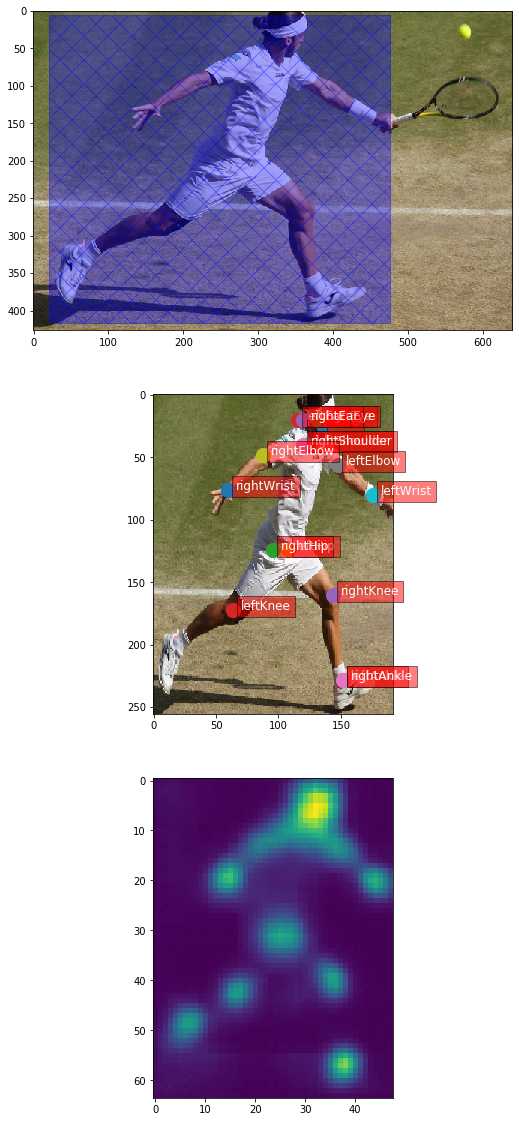

Inference time:  1.706782579421997


In [157]:
# Run the whole thing

start = time.time()
get_webcam_photo() # take photo from webcam
img = Image.open('photo.jpg') # load image
#img = Image.open('uploadedimage.jpg') # upload an image instead

person_boxes = detect_object_fastercnn(img) # detect all the person-bounding boxes

for idx ,pbox in enumerate(person_boxes): # loop through all the person detections
    print('---------------------------------------------')
    print("Person", idx+1, "of", len(person_boxes))
    print('---------------------------------------------')
    input_image_tensor, rescaled_img = preprocess_input_image(img, pbox) # preprocess images
    heatmap = get_heatmap_prediction(input_image_tensor) # predict heatmap
    keypoints, keypoint_scores = find_max_in_heatmap(heatmap) # find keypoint locations in heatmap
    plot_result(img, rescaled_img, pbox, keypoints, keypoint_scores, heatmap, idx) # plot result

end = time.time()
print("Inference time: ", end-start)

## Print a single heatmap

In [0]:
# plot heatmap of a single keypoint

# function to plot single keypoint
def plot_single_keypoint(keypoints,keypoint_scores,ax, score_threshold,kp_idx):
    keypoint_names = [
      "nose",
      "leftEye",
      "rightEye",
      "leftEar",
      "rightEar",
      "leftShoulder",
      "rightShoulder",
      "leftElbow",
      "rightElbow",
      "leftWrist",
      "rightWrist",
      "leftHip",
      "rightHip",
      "leftKnee",
      "rightKnee",
      "leftAnkle",
      "rightAnkle"]
  

    n = keypoint_names[kp_idx]
    x = keypoints[kp_idx,1]
    y = keypoints[kp_idx,0]

    if keypoint_scores[kp_idx]>score_threshold:
      ax.scatter(x, y, 200)
      ax.text(x+6, y, n, fontsize=12,bbox=dict(facecolor='red', alpha=0.5),color='w')

# function to plot images
def plot_heatmap(img, rescaled_img, pbox, keypoints, keypoint_scores, heatmap = None, idx = 0, kp_idx = 0):
    fig = plt.figure(idx,figsize=(20,20))

    # FIgure 2:
    # Plot the rescaled Image
    ax2 = fig.add_subplot(1,2, 1)
    ax2.imshow(rescaled_img)   
    # plot the keypoints
    plot_single_keypoint(keypoints, keypoint_scores, ax2, THRESHOLD, kp_idx)

    # Figure 3:
    ax3 = fig.add_subplot(1,2, 2)
    single_heatmap = heatmap[0,kp_idx,:,:]
    ax3.imshow(single_heatmap)

    plt.show()

In [159]:
for kp_idx in range(17):
  plot_heatmap(img, rescaled_img, pbox, keypoints, keypoint_scores, heatmap, kp_idx,kp_idx) # plot result

Output hidden; open in https://colab.research.google.com to view.